# We wanted to do something to reduce traffic in Austin with technology

--------------------------------------------------------------------------

# Can we reduce traffic congestion using existing infrastruction?

# Are our roads being used efficiently?

# How does traffic happen?

--------------------------------------------------------------------------

# Hypothsis: You can prevent traffic by controlling car density

----

## Traffic is well studied and has similar characteristics to fluid dynamics problems

### It displays several prominant characteristics
<img src="phase_transistions.png">

--------------------------------------------------------------------------

# What does traffic in Austin actually look like?

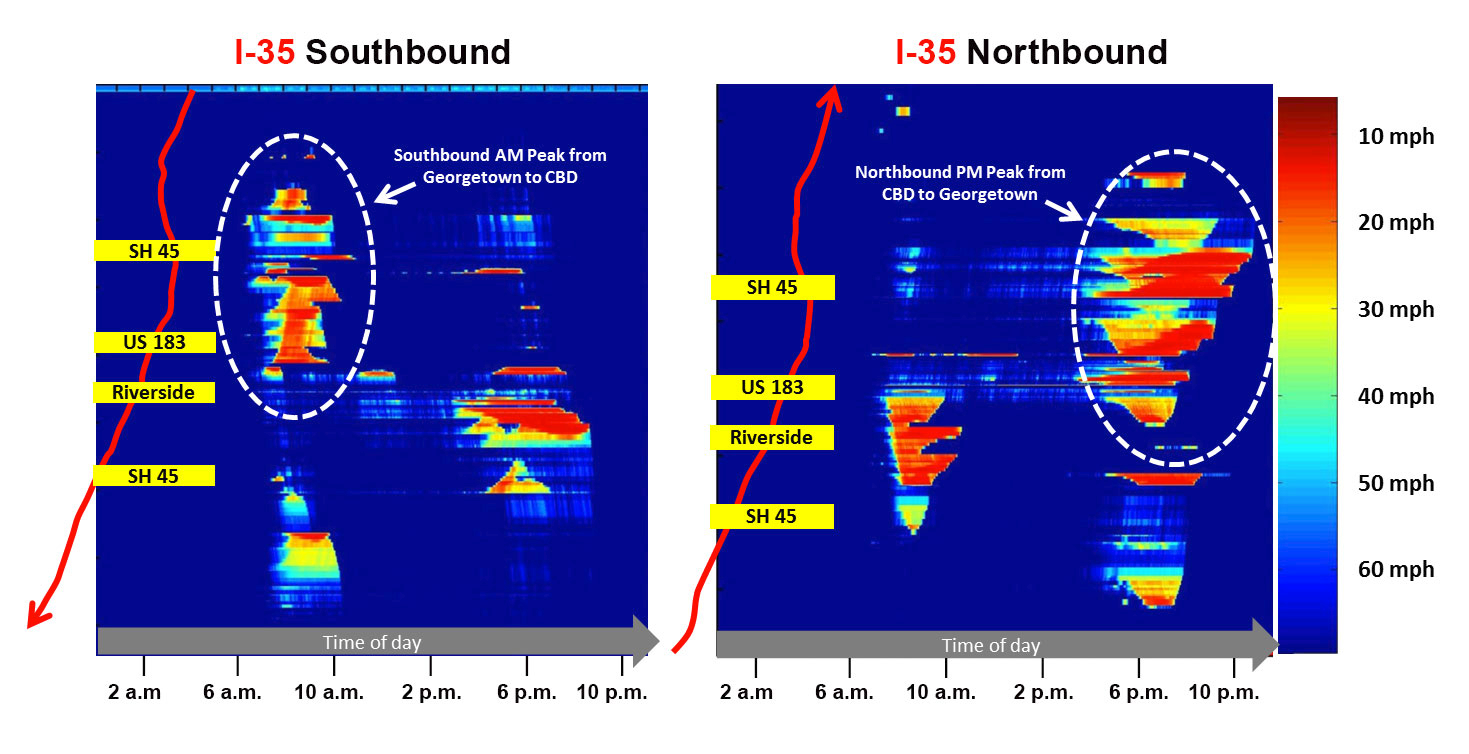

----

# Expected Result:
## We should see clear evidence of these phase transistions in Austin traffic

----

# We used data available from the Austin open data portal (data.austintexas.gov)

<img src="Austin-Data-Portal.png">

## The data set we analyized contains millions of records from bluetooth readers scattered across the city's roadways. In all, the data set contains about 96 million events.

----

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from datetime import datetime
from datetime import timedelta
import requests
from bokeh.charts import Line, output_file, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
#Load the data from the downloaded csv. Could also use the API.
df = pd.DataFrame.from_csv('Bluetooth_Travel_Sensors_-_Individual_Address_Files__IAF_.csv')

In [4]:
#Isolate the reads from either side of the I35 bridge over the river
riverside_df = df[df.reader_identifier.str.contains(r'ih_35_riverside')]
cesar_chavez_df = df[df.reader_identifier.str.contains(r'cesar_chavez_ih_35')]

In [5]:
#Merge the two subsets
bridge = riverside_df.merge(cesar_chavez_df, how='inner', on='device_address')

In [6]:
#Convert the datetimes to something handier
fmt = '%m/%d/%Y %I:%M:%S %p'
bridge['host_read_time_x'] = pd.to_datetime(bridge['host_read_time_x'], format = fmt)
bridge['host_read_time_y'] = pd.to_datetime(bridge['host_read_time_y'], format = fmt)
bridge['field_device_read_time_x'] = pd.to_datetime(bridge['field_device_read_time_x'], format=fmt)
bridge['field_device_read_time_y'] = pd.to_datetime(bridge['field_device_read_time_y'], format=fmt)

In [7]:
#The merge (an inner join of device ID) left a lot of noise (extra cartesian products).
#We filter these extra records out by attempting to match the most likely start and end times.
bridge_filtered = pd.DataFrame()
devices = set(bridge['device_address'])
for device in devices:
    device_records = bridge[bridge['device_address'] == device]
    read_times_x = set(device_records['host_read_time_x'])
    for read_time in read_times_x:
        time_x_records = device_records[device_records['host_read_time_x'] == read_time]
        time_diffs = np.abs(time_x_records['host_read_time_x'] - time_x_records['host_read_time_y'])
        bridge_filtered = bridge_filtered.append(bridge.iloc[time_diffs.argmin()])

In [8]:
bridge = bridge_filtered

In [9]:
#Segment the the events into northbound and southbound bridge traversals
northbound = bridge[bridge['host_read_time_x'] < bridge['host_read_time_y']]
southbound = bridge[bridge['host_read_time_y'] < bridge['host_read_time_x']]

In [10]:
#Find the actual time each traversal took
time_north = northbound['host_read_time_y'] - northbound['host_read_time_x']
time_south = southbound['host_read_time_x'] - southbound['host_read_time_y']
northbound = northbound.assign(time_north=time_north)
southbound = southbound.assign(time_south=time_south)

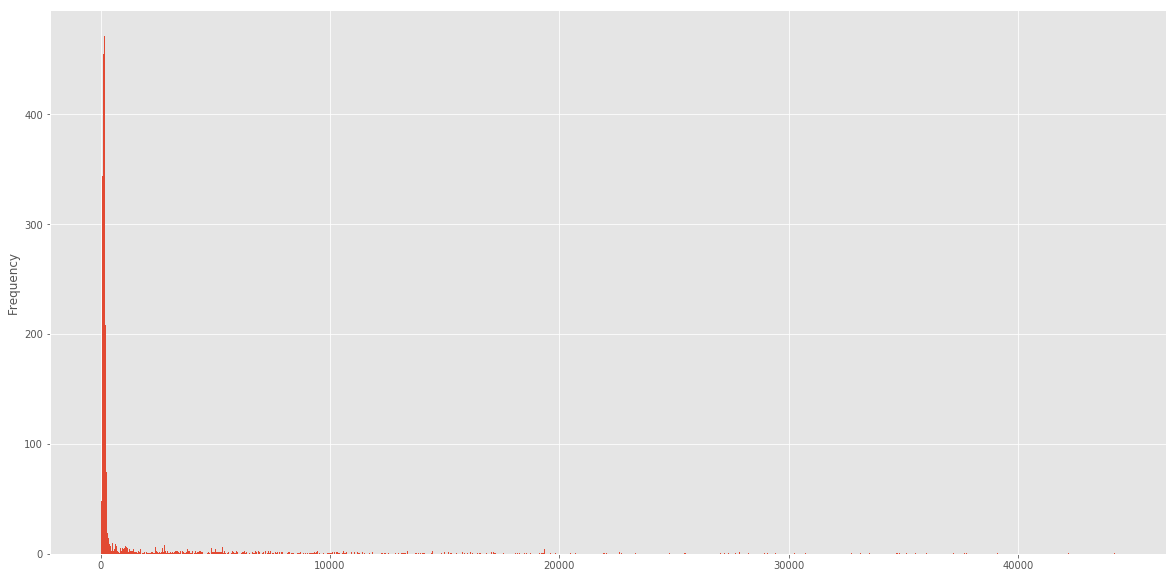

In [13]:
#Look to see how much noise is still left in the northbound data
plt.figure(figsize=(20,10))
northbound['time_north'].astype('timedelta64[s]').plot.hist(bins=1000)

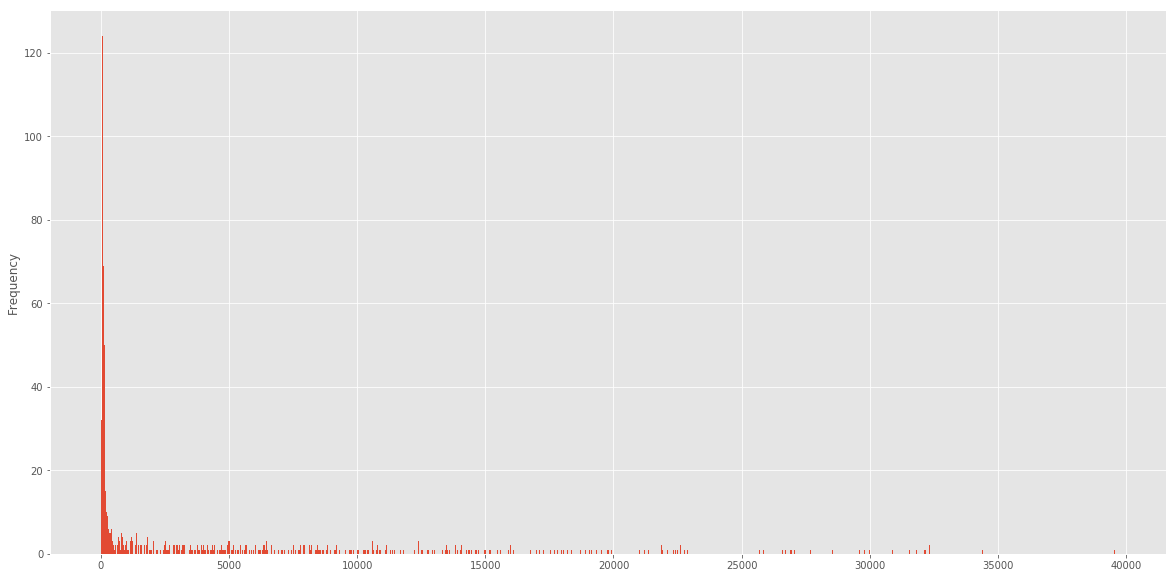

In [14]:
#And do the same for the southbound data
plt.figure(figsize=(20,10))
southbound['time_south'].astype('timedelta64[s]').plot.hist(bins=1000)

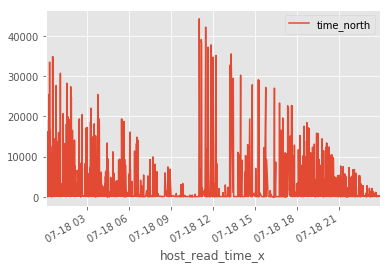

In [15]:
#Look at at the traversal time vs the time of the day for northbound traffic
plt.figure(figsize=(20,10))
northbound = northbound.assign(time_north=northbound['time_north'].astype('timedelta64[s]'))
northbound.plot(x='host_read_time_x', y='time_north')

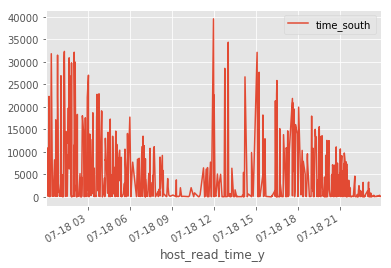

In [16]:
#Look at the traversal time vs the time of day for the southbound traffic
plt.figure(figsize=(20,10))
southbound = southbound.assign(time_south = southbound['time_south'].astype('timedelta64[s]'))
southbound.plot(x='host_read_time_y', y='time_south')

In [17]:
#bucket the date range for a dataframe so that we can do histograms and averages
def date_range(start, end, intv):
    while start < end:
        yield (start, start + intv)
        start += intv
    yield (start, start + intv)

#plot density vs time
def density_by_time(dataframe, start_column, end_column, delta):
    dataframe = dataframe.sort_values(by=start_column)
    x_list = dataframe[start_column].tolist()
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    counts = []
    for bucket in date_buckets:
        gtlb = dataframe[dataframe[start_column] >= bucket[0]]
        gtlb = gtlb[gtlb[start_column] < bucket[1]]
        ltub = gtlb[gtlb[end_column] > bucket[1]]
        counts.append(len(ltub))
        
    plt.plot([b[0] for b in date_buckets], counts)

#plot throughput (flow rate) vs time
def throughput_by_time(dataframe, exit_column, delta):
    #make sure the dataframe is sorted
    dataframe = dataframe.sort_values(by=exit_column)
    #turn the series into a list, easier to work with
    x_list = dataframe[exit_column].tolist()
    #create the buckets in even intervals during the time frame
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    #count the events we need to measure
    counts = []
    for bucket in date_buckets:
        #get events after the start of the bucket
        gtlb = dataframe[dataframe[exit_column] >= bucket[0]]
        #get events before end of bucket
        ltub = gtlb[gtlb[exit_column] < bucket[1]]
        
        counts.append(len(ltub))
        
    plt.plot([b[0] for b in date_buckets], counts)
    
def flow_by_density(dataframe, start_column, exit_column, delta):
    #sort
    dataframe = dataframe.sort_values(by=exit_column)
    #listify the series
    x_list = dataframe[exit_column].tolist()
    #bucket the series
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    #get counts for throughput
    throughput_counts = []
    for bucket in date_buckets:
        #get events after the start of the bucket
        gtlb = dataframe[dataframe[exit_column] >= bucket[0]]
        #get events before end of bucket
        ltub = gtlb[gtlb[exit_column] < bucket[1]]
        throughput_counts.append(len(ltub))
        
    #get counts for density
    density_counts = []
    for bucket in date_buckets:
        gtlb = dataframe[dataframe[start_column] >= bucket[0]]
        gtlb = gtlb[gtlb[start_column] < bucket[1]]
        ltub = gtlb[gtlb[exit_column] > bucket[1]]
        density_counts.append(len(ltub))
        
    fbd_points = [(throughput_counts[i], density_counts[i]) for i in range(len(date_buckets))]
    print(*zip(*fbd_points))
    plt.plot(*zip(*fbd_points))

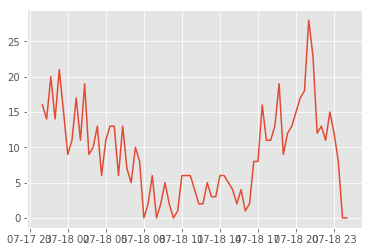

In [19]:
#There's a lot of varience, mostly because we don't have enough data to even things out, but 
#peaks in density can still be seen where we'd expect to see them (rush hour, lunch, etc...)
density_by_time(northbound, 'host_read_time_x', 'host_read_time_y', timedelta(minutes=20))

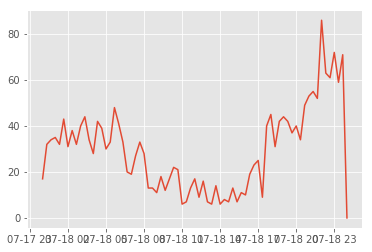

In [20]:
#Again, there's a lot of varience, but we still see nice peaks on the graph during
#peak travel times
throughput_by_time(northbound, 'host_read_time_y', timedelta(minutes=20))

(83, 110, 101, 118, 109, 111, 94, 79, 54, 41, 60, 26, 42, 27, 21, 31, 52, 74, 118, 123, 123, 160, 210, 202, 0) (39, 39, 26, 26, 18, 24, 22, 14, 8, 6, 2, 15, 4, 8, 14, 7, 9, 31, 37, 25, 37, 51, 26, 0, 0)


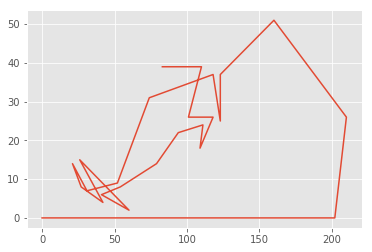

In [31]:
#Austin traffic is crazy.
#Clear evidence to phase transitions can be seen.
#This is (mostly) what we expected.
flow_by_density(northbound, 'host_read_time_x', 'host_read_time_y', timedelta(minutes=60))

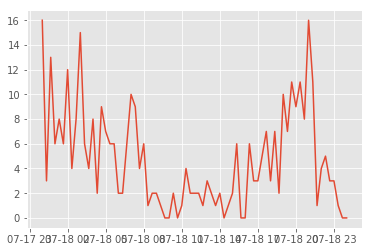

In [21]:
#The trends are still visible, but less data means even more varience.
density_by_time(southbound, 'host_read_time_y', 'host_read_time_x', timedelta(minutes=20))

In [ ]:
def bokeh_flow_by_density(dataframe, start_column, exit_column, delta):
    #sort
    dataframe = dataframe.sort_values(by=exit_column)
    #listify the series
    x_list = dataframe[exit_column].tolist()
    #bucket the series
    date_buckets = []
    for d in date_range(x_list[0], x_list[-1], delta):
        date_buckets.append(d)
        
    #get counts for throughput
    throughput_counts = []
    for bucket in date_buckets:
        #get events after the start of the bucket
        gtlb = dataframe[dataframe[exit_column] >= bucket[0]]
        #get events before end of bucket
        ltub = gtlb[gtlb[exit_column] < bucket[1]]
        throughput_counts.append(len(ltub))
        
    #get counts for density
    density_counts = []
    for bucket in date_buckets:
        gtlb = dataframe[dataframe[start_column] >= bucket[0]]
        gtlb = gtlb[gtlb[start_column] < bucket[1]]
        ltub = gtlb[gtlb[exit_column] > bucket[1]]
        density_counts.append(len(ltub))
        
    fbd_points = [(throughput_counts[i], density_counts[i]) for i in range(len(date_buckets))]
        
    line = Line([throughput_counts, density_counts])
    output_file('line.html')
    show(line)

In [ ]:
bokeh_flow_by_density(northbound, 'host_read_time_x', 'host_read_time_y', timedelta(minutes=20))